In [ ]:
pip install finterstellar

In [1]:
import finterstellar as fs

```python
def get_price(symbol, start_date=None, end_date=None):
    '''
    :param symbol: Symbol or ticker of equity by finance.yahoo.com
    :param start_date: The first date of period
    :param end_date: The last date of period
    :return: Historical close prices
    '''
    symbol = util.str_to_list(symbol)
    end_date = pd.to_datetime(end_date).date() if end_date else pd.Timestamp.today().date()
    start_date = pd.to_datetime(start_date).date() if start_date else util.months_before(end_date, 12)
    df = web.DataReader(symbol, 'yahoo', start=start_date, end=end_date)['Close'].round(2)
    return df[symbol]
```

In [2]:
df = fs.get_price('AAPL', start_date='2020-01-01', end_date='2020-12-31')
df

AAPL
2020-01-02  75.09
2020-01-03  74.36
2020-01-06  74.95
2020-01-07  74.60
2020-01-08  75.80
...           ...
2020-12-24 131.97
2020-12-28 136.69
2020-12-29 134.87
2020-12-30 133.72
2020-12-31 132.69

[253 rows x 1 columns]

```python
def draw_chart(df, left=None, right=None, log=False):
    '''
    Draw chart on each y-axis
    :param df: Dataframe that contains data to plot
    :param left: Columns to use left y-axis ticks
    :param right: Columns to use right y-axis ticks
    :param log: Plot in log scale
    :return: Line chart
    '''
    fig, ax1 = plt.subplots()
    x = df.index
    if left is not None:
        left = util.str_to_list(left)
        i = 6
        for c in left:
            ax1.plot(x, df[c], label=c, color='C'+str(i), alpha=1)
            i += 1
        if log:
            ax1.set_yscale('log')
            ax1.yaxis.set_major_formatter(ScalarFormatter())
            ax1.yaxis.set_minor_formatter(ScalarFormatter())
    else:
        ax1.axes.yaxis.set_visible(False)
    # secondary y
    if right is not None:
        right = util.str_to_list(right)
        ax2 = ax1.twinx()
        i = 1
        for c in right:
            ax2.plot(x, df[c], label=c+'(R)', color='C'+str(i), alpha=1)
            ax1.plot(np.nan, label=c+'(R)', color='C'+str(i))
            i += 1
        ax1.grid(False, axis='y')
        if log:
            ax2.set_yscale('log')
            ax2.yaxis.set_major_formatter(ScalarFormatter())
            ax2.yaxis.set_minor_formatter(ScalarFormatter())
    ax1.legend(loc=2)
    # plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

```

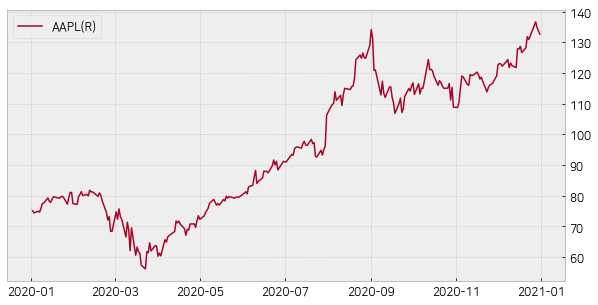

In [3]:
fs.draw_chart(df, right='AAPL')

```python
def rsi(df, w=14):
    '''
    Calculate RSI indicator
    :param df: Dataframe containing historical prices
    :param w: Window size
    :return: Series of RSI values
    '''
    pd.options.mode.chained_assignment = None
    symbol = df.columns[0]
    df.fillna(method='ffill', inplace=True)  # 들어온 데이터의 구멍을 메꿔준다
    if len(df) > w:
        df['diff'] = df.iloc[:,0].diff()   # 일별 가격차이 계산
        df['au'] = df['diff'].where(df['diff']>0, 0).rolling(w).mean()
        df['ad'] = df['diff'].where(df['diff']<0, 0).rolling(w).mean().abs()
        for r in range(w+1, len(df)):
            df['au'][r] = ( df['au'][r-1]*(w-1) + df['diff'].where(df['diff']>0,0)[r] ) / w
            df['ad'][r] = ( df['ad'][r-1]*(w-1) + df['diff'].where(df['diff']<0,0).abs()[r] ) / w
        df['rsi'] = (df['au'] / (df['au'] + df['ad']) * 100).round(2)
        return df[[symbol, 'rsi']]
    else:
        return None

```

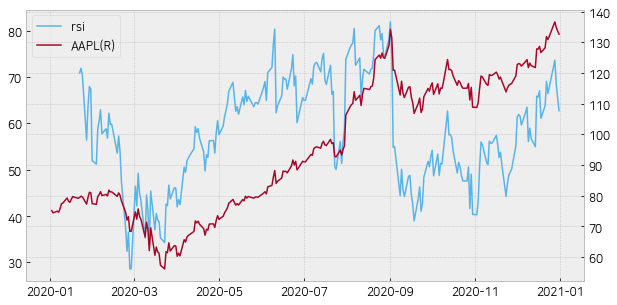

In [4]:
fs.rsi(df, w=14)
fs.draw_chart(df, left='rsi', right='AAPL')

```python
def indicator_to_signal(df, factor, buy, sell):
    '''
    Makes buy or sell signals according to factor indicator
    :param df: The dataframe containing stock prices and indicator data
    :param factor: The indicator to determine how to trade
    :param buy: The price level to buy
    :param sell: The price level to sell
    :return: The dataframe containing trading signal
    '''
    df['trade'] = np.nan
    if buy >= sell:
        df['trade'].mask(df[factor]>buy, 'buy', inplace=True)
        df['trade'].mask(df[factor]<sell, 'zero', inplace=True)
    else:
        df['trade'].mask(df[factor]<buy, 'buy', inplace=True)
        df['trade'].mask(df[factor]>sell, 'zero', inplace=True)
    df['trade'].fillna(method='ffill', inplace=True)
    df['trade'].fillna('zero', inplace=True)
    return df['trade']
```

In [5]:
fs.indicator_to_signal(df, factor='rsi', buy=40, sell=60)

2020-01-02    zero
2020-01-03    zero
2020-01-06    zero
2020-01-07    zero
2020-01-08    zero
              ... 
2020-12-24    zero
2020-12-28    zero
2020-12-29    zero
2020-12-30    zero
2020-12-31    zero
Name: trade, Length: 253, dtype: object

```python
def position(df):
    '''
    Determine the position of portfolio according to trading signals
    :param df: The dataframe containing trading signal
    :return: The dataframe containing trading position
    '''
    df['position'] = ''
    df['position'].mask((df['trade'].shift(1)=='zero') & (df['trade']=='zero'), 'zz', inplace=True)
    df['position'].mask((df['trade'].shift(1)=='zero') & (df['trade']=='buy'), 'zl', inplace=True)
    df['position'].mask((df['trade'].shift(1)=='buy') & (df['trade']=='zero'), 'lz', inplace=True)
    df['position'].mask((df['trade'].shift(1)=='buy') & (df['trade']=='buy'), 'll', inplace=True)
    
    df['position_chart'] = 0
    df['position_chart'].mask(df['trade']=='buy', 1, inplace=True)
    return df['position']
```

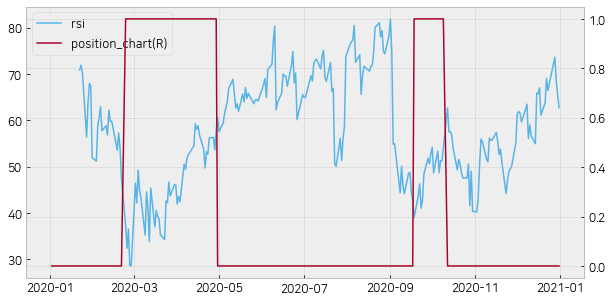

In [6]:
fs.position(df)
fs.draw_chart(df, left='rsi', right='position_chart')

```python
def evaluate(df, cost=.001):
    '''
    Calculate daily returns and MDDs of portfolio
    :param df: The dataframe containing trading position
    :param cost: Transaction cost when sell
    :return: Returns, MDD
    '''
    df['signal_price'] = np.nan
    df['signal_price'].mask(df['position']=='zl', df.iloc[:,0], inplace=True)
    df['signal_price'].mask(df['position']=='lz', df.iloc[:,0], inplace=True)
    record = df[['position','signal_price']].dropna()
    record['rtn'] = 1
    record['rtn'].mask(record['position']=='lz', (record['signal_price']*(1-cost))/record['signal_price'].shift(1), inplace=True)
    record['acc_rtn'] = record['rtn'].cumprod()
    df['signal_price'].mask(df['position']=='ll', df.iloc[:,0], inplace=True)
    df['rtn'] = record['rtn']
    df['rtn'].fillna(1, inplace=True)
    df['daily_rtn'] = 1
    df['daily_rtn'].mask(df['position'] == 'll', df['signal_price'] / df['signal_price'].shift(1), inplace=True)
    df['daily_rtn'].mask(df['position'] == 'lz', (df['signal_price']*(1-cost)) / df['signal_price'].shift(1), inplace=True)
    df['daily_rtn'].fillna(1, inplace=True)
    df['acc_rtn'] = df['daily_rtn'].cumprod()
    df['acc_rtn_dp'] = ((df['acc_rtn']-1)*100).round(2)
    df['mdd'] = (df['acc_rtn'] / df['acc_rtn'].cummax()).round(4)
    df['bm_mdd'] = (df.iloc[:, 0] / df.iloc[:, 0].cummax()).round(4)
    df.drop(columns='signal_price', inplace=True)
    return df
```

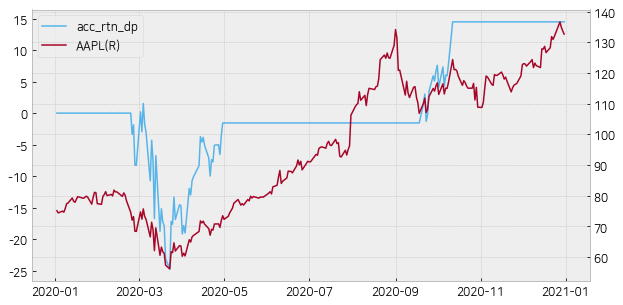

In [7]:
fs.evaluate(df, cost=.001)
fs.draw_chart(df, left='acc_rtn_dp', right='AAPL')

```python
def performance(df, rf_rate=.01):
    '''
    Calculate additional information of portfolio
    :param df: The dataframe with daily returns
    :param rf_rate: Risk free interest rate
    :return: Number of trades, Number of wins, Hit ratio, Sharpe ratio, ...
    '''
    rst = {}
    rst['no_trades'] = (df['position']=='zl').sum()
    rst['no_win'] = (df['rtn']>1).sum()
    rst['acc_rtn'] = df['acc_rtn'][-1].round(4)
    rst['hit_ratio'] = round((df['rtn']>1).sum() / rst['no_trades'], 4) if rst['no_trades']>0 else 0
    rst['avg_rtn'] = round(df[df['rtn']!=1]['rtn'].mean(), 4)
    rst['period'] = __get_period(df)
    rst['annual_rtn'] = __annualize(rst['acc_rtn'], rst['period'])
    rst['bm_rtn'] = round(df.iloc[-1,0]/df.iloc[0,0], 4)
    rst['sharpe_ratio'] = __get_sharpe_ratio(df, rf_rate)
    rst['mdd'] = df['mdd'].min()
    rst['bm_mdd'] = df['bm_mdd'].min()

    print('CAGR: {:.2%}'.format(rst['annual_rtn'] - 1))
    print('Accumulated return: {:.2%}'.format(rst['acc_rtn'] - 1))
    print('Average return: {:.2%}'.format(rst['avg_rtn'] - 1))
    print('Benchmark return : {:.2%}'.format(rst['bm_rtn']-1))
    print('Number of trades: {}'.format(rst['no_trades']))
    print('Number of win: {}'.format(rst['no_win']))
    print('Hit ratio: {:.2%}'.format(rst['hit_ratio']))
    print('Investment period: {:.1f}yrs'.format(rst['period']/365))
    print('Sharpe ratio: {:.2f}'.format(rst['sharpe_ratio']))
    print('MDD: {:.2%}'.format(rst['mdd']-1))
    print('Benchmark MDD: {:.2%}'.format(rst['bm_mdd']-1))
    return

```

In [8]:
fs.performance(df, rf_rate=0.01)

CAGR: 15.39%
Accumulated return: 14.50%
Average return: 7.38%
Benchmark return : 67.05%
Number of trades: 2
Number of win: 1
Hit ratio: 50.00%
Investment period: 0.9yrs
Sharpe ratio: 0.33
MDD: -25.89%
Benchmark MDD: -31.43%


CAGR: 47.34%
Accumulated return: 44.62%
Average return: 45.31%
Benchmark return : 67.05%
Number of trades: 2
Number of win: 1
Hit ratio: 50.00%
Investment period: 0.9yrs
Sharpe ratio: 1.25
MDD: -30.45%
Benchmark MDD: -31.43%


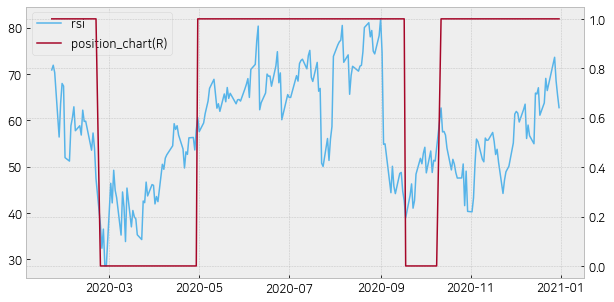

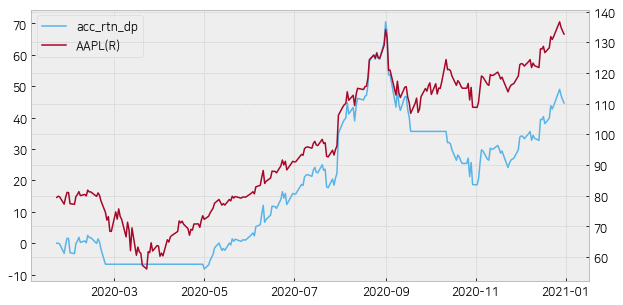

In [9]:
fs.indicator_to_signal(df, factor='rsi', buy=60, sell=40)
fs.position(df)
fs.evaluate(df, cost=.001)
fs.performance(df, rf_rate=0.01)
fs.draw_chart(df, left='rsi', right='position_chart')
fs.draw_chart(df, left='acc_rtn_dp', right='AAPL')